# Assignment 3 
Names:
Michael MacFarlane Glasow  
Rinske Oskamp  
Ruben Lanjouw  

Git fame:
| Author   |   loc |   coms |   fils |  distribution   |
|:---------|------:|-------:|-------:|:----------------|
| RubenYDL |  1955 |      8 |     14 | 94.6/72.7/93.3  |
| Rinske   |   112 |      3 |      1 | 5.4/27.3/ 6.7   |
  
  

NOTE: Git was screwed again. IPYNB are not easy to manage in git. Thats why we decided to make the code in python first. Michael moslty made the plots and the hypothesis tested, thats why its not vissable in the git Fame. This ipynb does not contain the code for the plots but can be requested. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [28]:
# read the data files
def read_file(file="a280.tsp.txt"):
    folder= "./TSP-Configurations/"
    file = open(folder + file, "r")
    lines = file.readlines()
    file.close()

    # skip the beginning!
    lines = lines[6:-1]
    lines = [line.split() for line in lines]
    lines = [[int(line[0]), float(line[1]), float(line[2])] for line in lines]
    return lines

# calculate the distance between two nodes with pythagoras theorem
def distance_two_nodes(node1, node2):
    x1, y1 = node1[1], node1[2]
    x2, y2 = node2[1], node2[2]
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)


# calculate total distance of a route 
def distance_route(route):
    total_distance = 0
    for i in range(len(route)-1):
        total_distance += distance_two_nodes(route[i], route[i+1])
    total_distance += distance_two_nodes(route[-1], route[0])
    return total_distance

# make random route
def random_route(coordinates):  
    start = coordinates[0]
    end = coordinates[0]
    cities = coordinates[1:]
    route = [start] + list(np.random.permutation(cities)) + [end]
    return np.array(route)


In [29]:
def two_opt_alg(route):
    new_route = route.copy()
    n= len(route)
    # always min 3 cities
    i = np.random.choice(np.arange(1, n-2))
    j = i + 1
    p = np.random.choice(np.arange(j+1, n))
    # q = p + 1
    new_route[j:p] = new_route[j:p][::-1]
    return new_route

def simulated_annealing(route, initial_temp=10000, cooling_rate=0.995, iterations=100000, coolingsc = "lin", markov_chain_length=1, verbose=True, cooling=True):
    if type(iterations) == list:
        lijst = iterations
        iterations = iterations[-1]
    current_route = route
    current_distance = distance_route(route)
    best_route = current_route
    best_distance = current_distance
    temperature = initial_temp
    minimum = False
    final_temp = 1
    results = []
    step_size= initial_temp/ (cooling_rate * iterations)
    temp = []

    for iteration in range(iterations):
        # Generate a neighboring solution using 2-opt
        new_route = two_opt_alg(current_route)
        new_distance = distance_route(new_route)
        if cooling:
            if new_distance < current_distance or np.random.rand() < np.exp((current_distance - new_distance) / temperature):
                current_route = new_route
                current_distance = new_distance
                if current_distance < best_distance:
                    best_route = current_route
                    best_distance = current_distance

            if iteration % markov_chain_length == 0 and temperature > 10**-7:
                if coolingsc == "lin":
                    temperature = max(10**-7,temperature - step_size)
                if coolingsc == "exp":
                    temperature = max(10**-7,temperature * cooling_rate)
                if coolingsc == "log":
                    temperature = max(10**-7,temperature / (1 + np.log(1 + iteration)))
        else:
            if new_distance < best_distance:
                best_route = new_route
                best_distance = new_distance

        if iteration in lijst:
            results.append(best_distance)
            temp.append(temperature)
        if verbose and (iteration % 10000 == 0 and iteration != 0):
            print(f"Iteration: {iteration}, Best distance: {best_distance}, Temperature: {temperature}")
    return best_route, best_distance, results, temp


    
def bruteforce_two_opt_alg(route, iterations,gap=1000):
    best_route = route
    best_distance = distance_route(route)
    results = []
    for i in range(iterations):
        new_route = two_opt_alg(best_route)
        new_distance = distance_route(new_route)
        if new_distance < best_distance:
            best_route = new_route
            best_distance = new_distance
        if i % gap == 0:
            results.append(best_distance)
    return best_route, best_distance, results



In [30]:
coordinates = read_file()
initial_route = random_route(coordinates)
cooling_schedules = ["lin", "exp", "log"]
iterations = list(range(0,1001,100))
results = []
initial_route = random_route(coordinates)
for coolingsc in cooling_schedules:
    distances = []
    for i in range(10):
        best_route, best_distance, res, temp = simulated_annealing(initial_route, iterations=iterations, coolingsc=coolingsc)
        distances.append(res)
    results.append([coolingsc, iterations, distances])
    print(f"Done with {coolingsc}")

# save the results 
np.save("lin.npy", results[0][2])
np.save("exp.npy", results[1][2])
np.save("log.npy", results[2][2])


Done with lin
Done with exp
Done with log


In [31]:
# code to find the fastest route with a bad algorithm
def get_optimum(route):
    folder= "TSP-Configurations/"
    file = open(folder + "a280.opt.tour.txt", "r")
    lines = file.readlines()
    file.close()
    lines = lines[4:-2]
    lines = [int(line) for line in lines]

    empty_list = [0] * len(lines)
    for item in route:
        city_number = item[0]
        matching_index = lines.index(int(city_number))
        empty_list[matching_index] = item
    return empty_list

coordinates = read_file()
initial_route = random_route(coordinates)
distance_route(get_optimum(initial_route))

2586.7696475631606

### Example Plot:

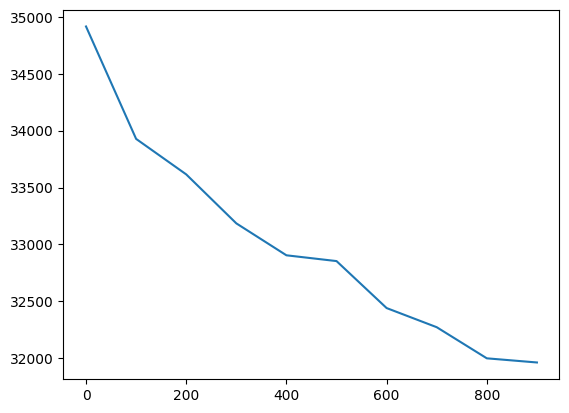

In [32]:
# example plot
lin = np.load("lin.npy")
exp = np.load("exp.npy")
log = np.load("log.npy")
plt.plot(iterations[:10],np.mean(lin, axis=0), label="Linear")